Las mediciones que queremos hacer aquí son las siguientes:
- Velocidad promedio respecto al número de autos:
    - Promedio sobre los días - Termalización
    - Promedio usando el mismo número de autos pero diferente distribución de orígenes destinos
   
- Ver con qué número de autos se alcanza la saturación y meter diferentes tipos de diagonales.
- ¿Los autos regresan a caminos previos? ¿Se forman ciclos? ¿Hay estados estacionarios?

La velocidad de cada auto en todo su trayecto:
- Distancia en su recorrido total entre t_llegada-t_salida.
- Distancia absoluta entre t_llegada-t_salida.
- El promedio de su diccionario propio de velocidades.

Gráficas de cómo avanzan estas variables a través de los días para densidades de auto fijas, y luego para el día n cómo cambian para diferentes densidades.

Distancia promedio (sobre la red) que recorren los automóviles.

Hasta dónde puedo hacer crecer la red.

Verificar si los autos van cambiando de ruta conforme pasan los días.

Es más probable que haya efectos en casos donde hay diagonales

In [1]:
using DataFrames, GraphPlot, Impute, Plots, Colors, Statistics

include("funciones_de_red.jl")
include("objetos.jl")
include("dinamica_conductores.jl")
include("animaciones.jl")

plot_digraph (generic function with 1 method)

## Generación de la red 

In [2]:
"""
    create_network(side_number, both_ways)
generates a complete network object, that contains a LightGraphs digraph, a position array
and a city matrix, a 3D object that contains information about:
- Minimum time to go trough each edge.
- Capacity of each edge.
- Number of cars in each one of the edges. It starts at cero.
- Real time to go trough each edge, following the BPR function. At the beginning is the 
    same as the minimum time.

The digraph created will be an square network with *side_number* of nodes in each side,
and will be slow in the corners.
You can choose if the streets are both-ways or not using the *both_ways* parameter
(default value: one way.)
"""
function create_square_network(side_number::Integer; both_ways=true)
    SquareNet, position_array, dist_matrix = SquareDiGraph(side_number, doble_sentido=both_ways);
    SquareNet, position_array, dist_matrix = make_slow_corners(SquareNet, position_array, dist_matrix);
    
    m = nv(SquareNet);
    city_matrix = zeros(m,m,4);
    f = x -> [speed(i,j,x) for i in 1:length(x),j in 1:length(x)];
    city_matrix[:,:,1] = dist_matrix./f(position_array);
    city_matrix[:,:,2] = dist_matrix.*3/5;
    city_matrix[:,:,4] = BPR.(city_matrix[:,:,1], city_matrix[:,:,3],city_matrix[:,:,2]);
    red_cuadrada=network(SquareNet,position_array,city_matrix);
    return red_cuadrada
end

create_square_network

In [3]:
red_cuadrada = create_square_network(5);
SqNet= red_cuadrada.digraph;
m = nv(SqNet);
posarr = red_cuadrada.position_array;
city_mt = red_cuadrada.city_matrix;

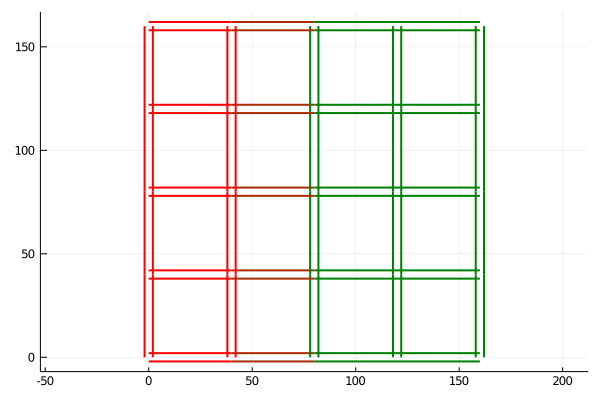

In [4]:
plot_digraph(SqNet, posarr,attribute_matrix=city_mt[:,:,4], separated_edges=true)

## Generación de los autos 

In [5]:
function generate_auto(m,t,red)
    o = rand(1:m)
    d = collect(1:m)
    splice!(d,o)
    d = d[rand(1:end)]
    h = 0.5 #h es la porporción que corresponde a la memoria
    return auto(o,d,t,h,red)
end

function generate_autos(m, red, n_cars, ti, tf)
    step = (tf-ti)/(n_cars-1)
    autos = [generate_auto(m,t,red) for t in collect(ti:step:tf)]
    return autos
end

generate_autos (generic function with 1 method)

In [6]:
function get_avg_vel(autos)
    avg_vels = [mean(values(auto.speed_memory)) for auto in autos]
    return minimum(avg_vels), mean(avg_vels)
end

get_avg_vel (generic function with 1 method)

In [10]:
function simulacion_completa(side_number, both_ways, n_cars, ti, tf)
    red_cuadrada = create_square_network(side_number, both_ways=both_ways);
    m = nv(red_cuadrada.digraph)
    autos = generate_autos(m,red_cuadrada,n_cars,ti,tf)
    n = 200
    day = 0
    min_vels = []
    avg_vels = []
    cars_changing = []
    
    while n > 0 
        print("día $(day) \n")
        times, vels = simulacion!(0., red_cuadrada, autos);
        min_vel, avg_vel = get_avg_vel(autos)
        push!(min_vels,min_vel)
        push!(avg_vels,avg_vel)
        
        print(min_vel," ", avg_vel,"\n")
        old_n = n
        n = restart(autos, red_cuadrada)
        push!(cars_changing, n)
        
        if old_n == n
            break
        end
        
        day += 1
    end
    return min_vels, avg_vels, cars_changing
end

simulacion_completa (generic function with 1 method)

In [11]:
min_vels, avg_vels, cars_changing = simulacion_completa(5,true,2000,0.,150.)

día 0 
7.999672757366536 11.426086269063074
842 cars changed A* path 
día 1 
7.9997818382357435 11.46405162299961
469 cars changed A* path 
día 2 
7.9997818382357435 11.45258352112759
225 cars changed A* path 
día 3 
7.99977895400605 11.453434554421259
98 cars changed A* path 
día 4 
7.9997818382357435 11.453125520677146
39 cars changed A* path 
día 5 
7.9997818382357435 11.453417025151898
13 cars changed A* path 
día 6 
7.9997818382357435 11.453358682639674
4 cars changed A* path 
día 7 
7.9997818382357435 11.453358679924914
2 cars changed A* path 
día 8 
7.9997818382357435 11.453300349370975
1 cars changed A* path 
día 9 
7.9997818382357435 11.45330034936634
0 cars changed A* path 


(Any[7.999672757366536, 7.9997818382357435, 7.9997818382357435, 7.99977895400605, 7.9997818382357435, 7.9997818382357435, 7.9997818382357435, 7.9997818382357435, 7.9997818382357435, 7.9997818382357435], Any[11.426086269063074, 11.46405162299961, 11.45258352112759, 11.453434554421259, 11.453125520677146, 11.453417025151898, 11.453358682639674, 11.453358679924914, 11.453300349370975, 11.45330034936634], Any[842, 469, 225, 98, 39, 13, 4, 2, 1, 0])

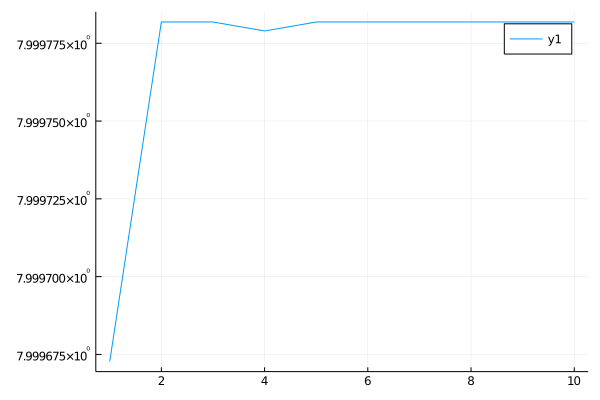

In [12]:
plot(min_vels)

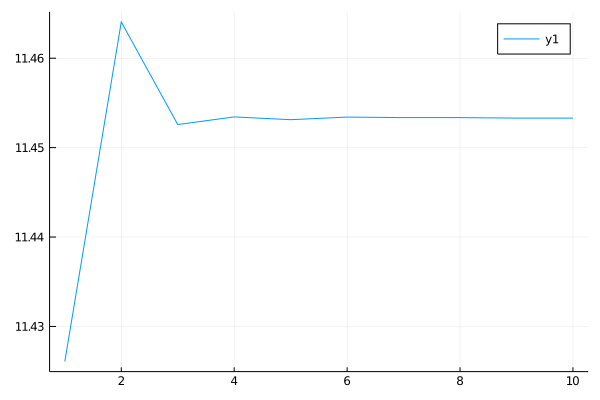

In [13]:
plot(avg_vels)

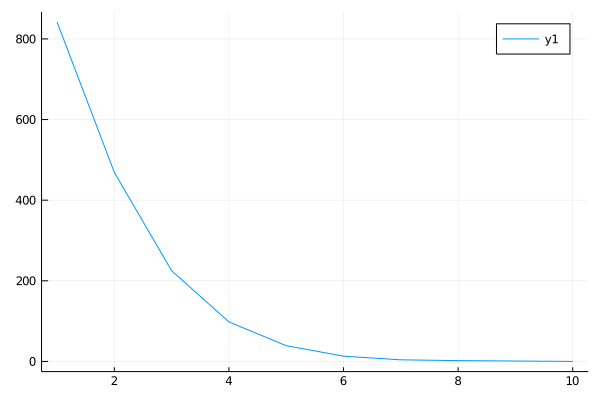

In [14]:
plot(cars_changing)

Ir imprimendo porcentaje de autos que ha salido y llegado cada n pasos de tiempo

Siguientes pasos:
- Calles de 25-40 m
- Más calles
- Autos de 4m
- Mediciones

Paralelizar sobre las densidades
Revisar el problema de los NaN y que se está incrementando la velocidad en vez de reducirse, corregir velocidades/tiempo. La posición inicial y el destino deben estar separados al menos cierta distancia

todos salen de un lado y todos llegan al lado opuesto

Tratar de hacer una red más grande